[Home](index.ipynb) > [Notebooks](notebooks.ipynb) > Constructing networks

<img style='float: left;' src='https://www.gesis.org/typo3conf/ext/gesis_web_ext/Resources/Public/webpack/dist/img/logo_gesis_en.svg' width='150'>

### ``compsoc`` – Computational Social Methods in Python

# Constructing networks from node and edge lists

**Author**: [Haiko Lietz](https://www.gesis.org/person/haiko.lietz)

**Affiliation**: [GESIS - Leibniz Institute for the Social Sciences](https://www.gesis.org/), Cologne, Germany

**Publication date**: XX.XX.XXXX (version 1.0)

***

## Introduction

**Graph** is the mathematical name for a network. A graph consists of a set of nodes (graph-theoretically called vertices) and a set of edges. `compsoc` systematically builds on this formalism because it helps the researcher to stay in full control of the data and the research done with it. Practically, this means that the data from which networks are constructed lives in two tables or dataframes: a node list and an edge list. The **node list** contains all information about the nodes and their attributes. Similarly, the **edge list** contains all information about the edges and their attributes, including edge weights or types.

The node and edge lists are also the ideal places to store results from network analysis. To be able to do that, it is important to keep them tidy. This includes that nodes are systematically indexed with a continuous identifier from $0$ to $N-1$ where $N$ is the number of nodes.

**In this notebook**, we show how graphs are constructed from node and edge lists. We start with simple graphs and, step by step, introduce the routines to build more complicated attributed networks. From these steps, we build the `construct_graph()` function that builds networks from node and edge lists and frees the user from any coding.

[graph-tool](https://graph-tool.skewed.de/) is the package of choice because it allows for constructing and analyzing very large networks up to millions of nodes and edges and is built for speed. It also requires rigorous tidiness of coding which goes very well with the `compsoc` philosophy. Data from the [Copenhagen Networks Study](copenhagen.ipynb) is used for demonstration purposes because it is a role model of digital behavioral data and many different kinds of networks can be constructed from it.

## Dependencies and settings

In [1]:
import compsoc as cs
import graph_tool.all as gt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colormaps

## Node and edge lists

`compsoc` uses a standardized data format that contains tables that can directly be used as node and edge lists. Load the data:

In [2]:
users, genders, bluetooth, calls, sms, facebook_friends = cs.copenhagen_collection()

The `users` dataframe is the node list with 845 nodes:

In [3]:
users

,user_id,user,gender_id
0,0,0,0
1,1,1,2
2,2,2,0
3,3,3,0
4,4,4,0
...,...,...,...
840,840,845,0
841,841,846,0
842,842,847,1
843,843,848,2


The following cell checks if the 'user_id' column contains integers from $0$ to $N-1$ where $N$ is the number of vertices in the graph:

In [4]:
users = users.sort_values('user_id', ascending=True).reset_index(drop=True)
check = users['user_id'] == users.index
if (sum(check) == len(users)):
    print('The node list dataframe meets the requirements.')

The node list dataframe meets the requirements.


There are four edge lists, each representing a type of tie.

### Starting simple: Facebook friendship relations

Graph construction with `graph-tool` is a stepwise process, particularly if there are many node and edge attributes. Let's start with a simple undirected unweighted graph, Facebook friendship:

In [5]:
facebook_friends.head()

,# user_a,user_b,user_id_from,user_id_to
0,0,104,0,104
1,0,107,0,107
2,0,108,0,108
3,0,208,0,208
4,0,263,0,263


The first step is to create an empty `Graph` object, here, an undirected one:

In [6]:
g_facebook_friends = gt.Graph(directed=False)

In [7]:
g_facebook_friends.is_directed()

False

Edges are added to the graph using the `add_edge_list()` method. Adding edges will automatically add nodes to the graph. The needed input is an array which we can obtain by taking the values of the `facebook_friends` edge list:

In [8]:
g_facebook_friends.add_edge_list(facebook_friends[['user_id_from', 'user_id_to']].values)

In [9]:
print('Number of Nodes:', g_facebook_friends.num_vertices())
print('Number of edges:', g_facebook_friends.num_edges())

Number of Nodes: 845
Number of edges: 6429


The graph has 845 nodes. This tells us that all users from the node list have been added to the graph, but it does not mean that all nodes have edges.

Draw the largest component of the friendship network using the [`graph_draw()`](https://graph-tool.skewed.de/static/doc/draw.html#graph_tool.draw.graph_draw) function (learn [here](https://graph-tool.skewed.de/static/doc/autosummary/graph_tool.draw.graph_draw.html) about drawing options):

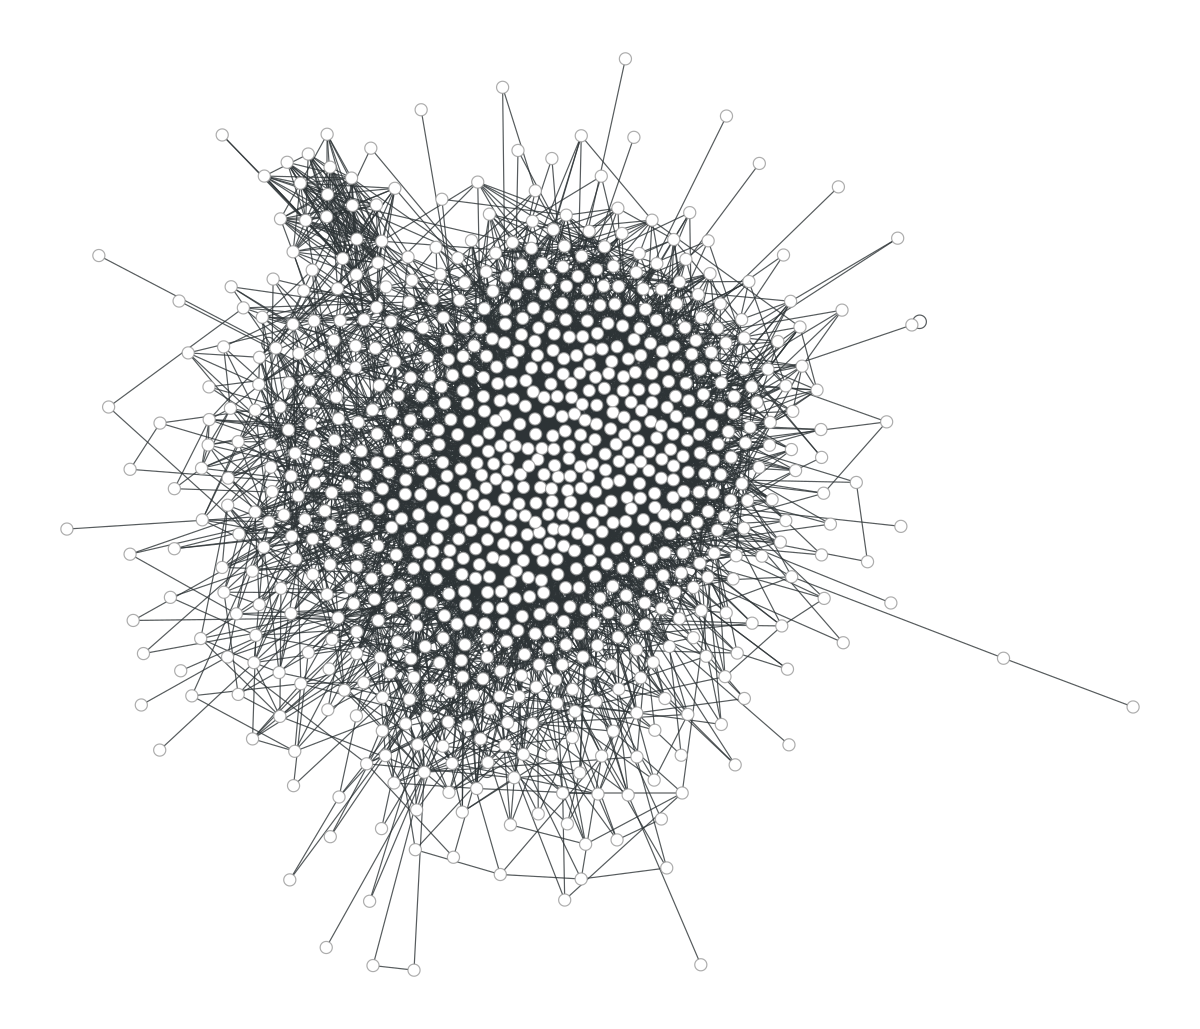

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2921095650, at 0x7f29298a2e10>

In [10]:
pos_facebook_friends = gt.sfdp_layout(g_facebook_friends)
gt.graph_draw(
    g = gt.extract_largest_component(g_facebook_friends), 
    pos = pos_facebook_friends, 
    vertex_fill_color = 'white'
)

### Node attributes

As a next step, we want to add attributes to the graph. The node list already contains an attribute: the gender identifier. `graph-tool` stores attributes in so-called node [property maps](https://graph-tool.skewed.de/static/doc/quickstart.html#property-maps). To store the gender attribute, create a new map (`new_vp()` is short for `new_vertex_property()`):

In [11]:
g_facebook_friends_vp_gender_id = g_facebook_friends.new_vp('int')

Property maps with scalar value types can be accessed as a array (the `a` attribute is short for `get_array()`:

In [12]:
g_facebook_friends_vp_gender_id.a = users['gender_id']

Other attributes may derive from an analysis of a network. To demonstrate what it means to be tidy and "stay in full control" of the research, we compute the number of friends per student, store it in the node list, ...

In [13]:
users.loc[:, 'num_friends'] = g_facebook_friends.get_out_degrees(g_facebook_friends.get_vertices())

... create a new vertex property map for the number of friends, and write the numbers from the node list into the map:

In [14]:
g_facebook_friends_vp_num_friends = g_facebook_friends.new_vp('int')
g_facebook_friends_vp_num_friends.a = users['num_friends']

Now we can draw the largest component of the friendship network network, enriched with two node attributes:

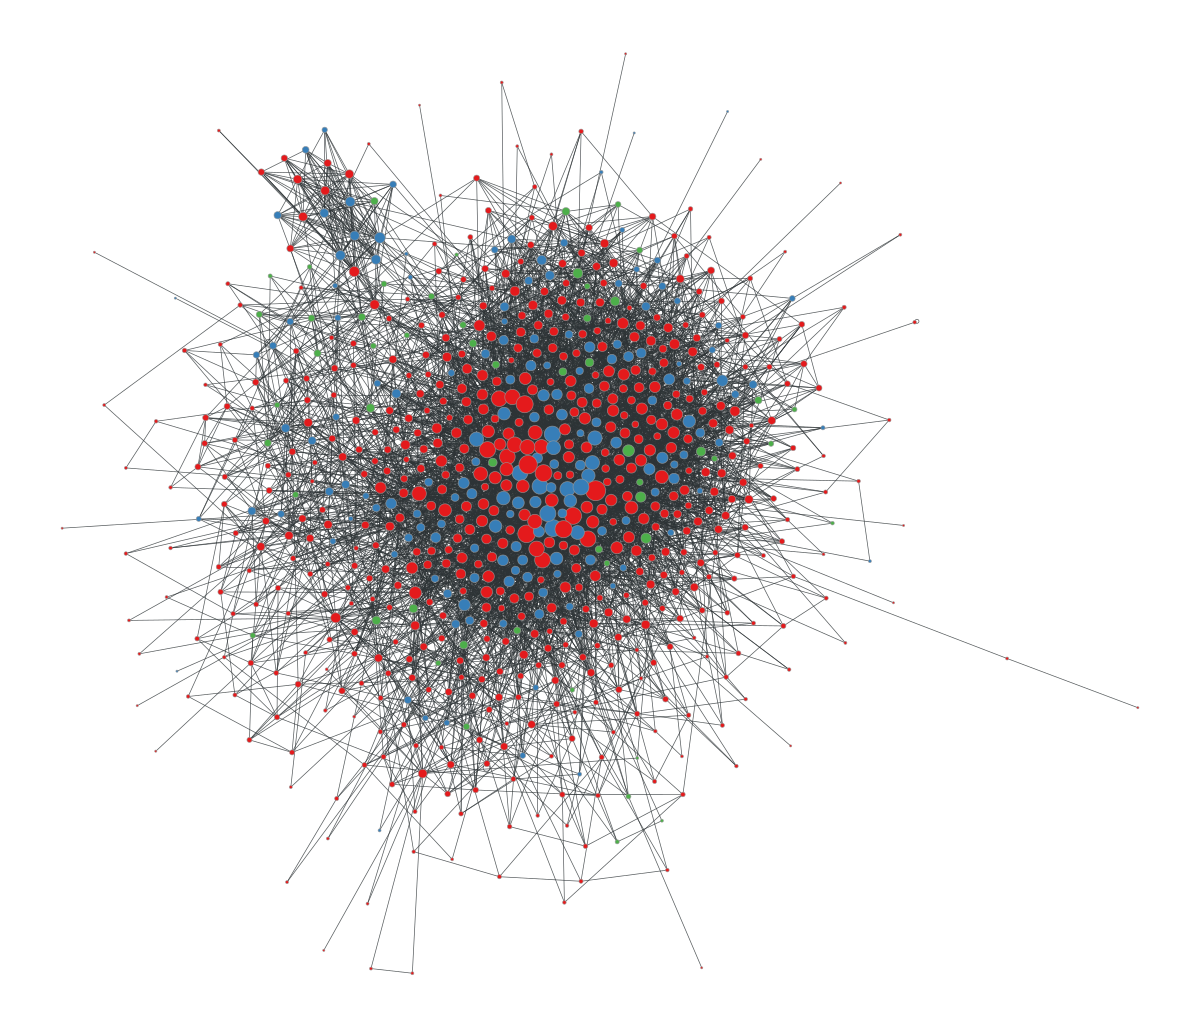

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2921095650, at 0x7f292106c050>

In [15]:
gt.graph_draw(
    g = gt.extract_largest_component(g_facebook_friends), 
    pos = pos_facebook_friends, 
    vertex_fill_color = g_facebook_friends_vp_gender_id, 
    vertex_size = gt.prop_to_size(prop=g_facebook_friends_vp_num_friends, mi=.1, ma=10), 
    vcmap = colormaps['Set1']
)

### Directed weighted graph: Who calls whom?

As soon as edges are directed or weighted, the graph is not called "simple" anymore. The network of phone calls is such a graph. Create the `Graph` object:

In [16]:
g_calls = gt.Graph(directed=True)

The `calls` dataframe contains one call per row including the duration of the call:

In [17]:
calls.head()

,user_id_from,user_id_to,duration,time,time_bin
0,300,301,121,1970-01-01 00:03:04,0
1,512,299,670,1970-01-01 01:05:20,13
2,301,300,504,1970-01-01 01:33:43,18
3,401,457,0,1970-01-01 02:34:12,30
4,512,0,5,1970-01-01 04:17:46,51


`graph-tool` would create one edge for each row. As a result, students who call another would have multiple edges. To only have one edge per direction, we have to aggregate the edge list first. We chose to sum all call durations per edge:

In [18]:
calls_sum = calls[['user_id_from', 'user_id_to', 'duration']].groupby(['user_id_from', 'user_id_to']).sum().reset_index()

Rename the column containing the edge weight to 'weight':

In [19]:
calls_sum.rename(columns={'duration': 'weight'}, inplace=True)

`graph-tool` also stores edge weights as edge attributes in edge [property maps](https://graph-tool.skewed.de/static/doc/quickstart.html#property-maps). Before we can add the edge list including the edge weights to the graph, we must prepare such an edge property map. Create a new edpe property map called `g_calls_ep_weight` of the type 'int' (`new_ep()` is short for `new_edge_property()`):

In [20]:
g_calls_ep_weight = g_calls.new_ep('int')

Now we can add the edges to the graph. Note that the edge weight must be in the third column of the array, which is the case:

In [21]:
g_calls.add_edge_list(calls_sum.values, eprops=[g_calls_ep_weight])

In [22]:
g_calls

<Graph object, directed, with 842 vertices and 924 edges, at 0x7f2921097050>

The graph we have just created has 842 nodes, not all 845 which are in the node list. This is because the last node in the list to have made or received a call is 842. For the graph to have all nodes, 845 nodes must be added to the graph *before* the edges are added (line 2):

In [23]:
g_calls = gt.Graph(directed=True)
g_calls.add_vertex(len(users))
g_calls_ep_weight = g_calls.new_ep('int')
g_calls.add_edge_list(calls_sum.values, eprops=[g_calls_ep_weight])

In [24]:
g_calls

<Graph object, directed, with 845 vertices and 924 edges, at 0x7f29781cf050>

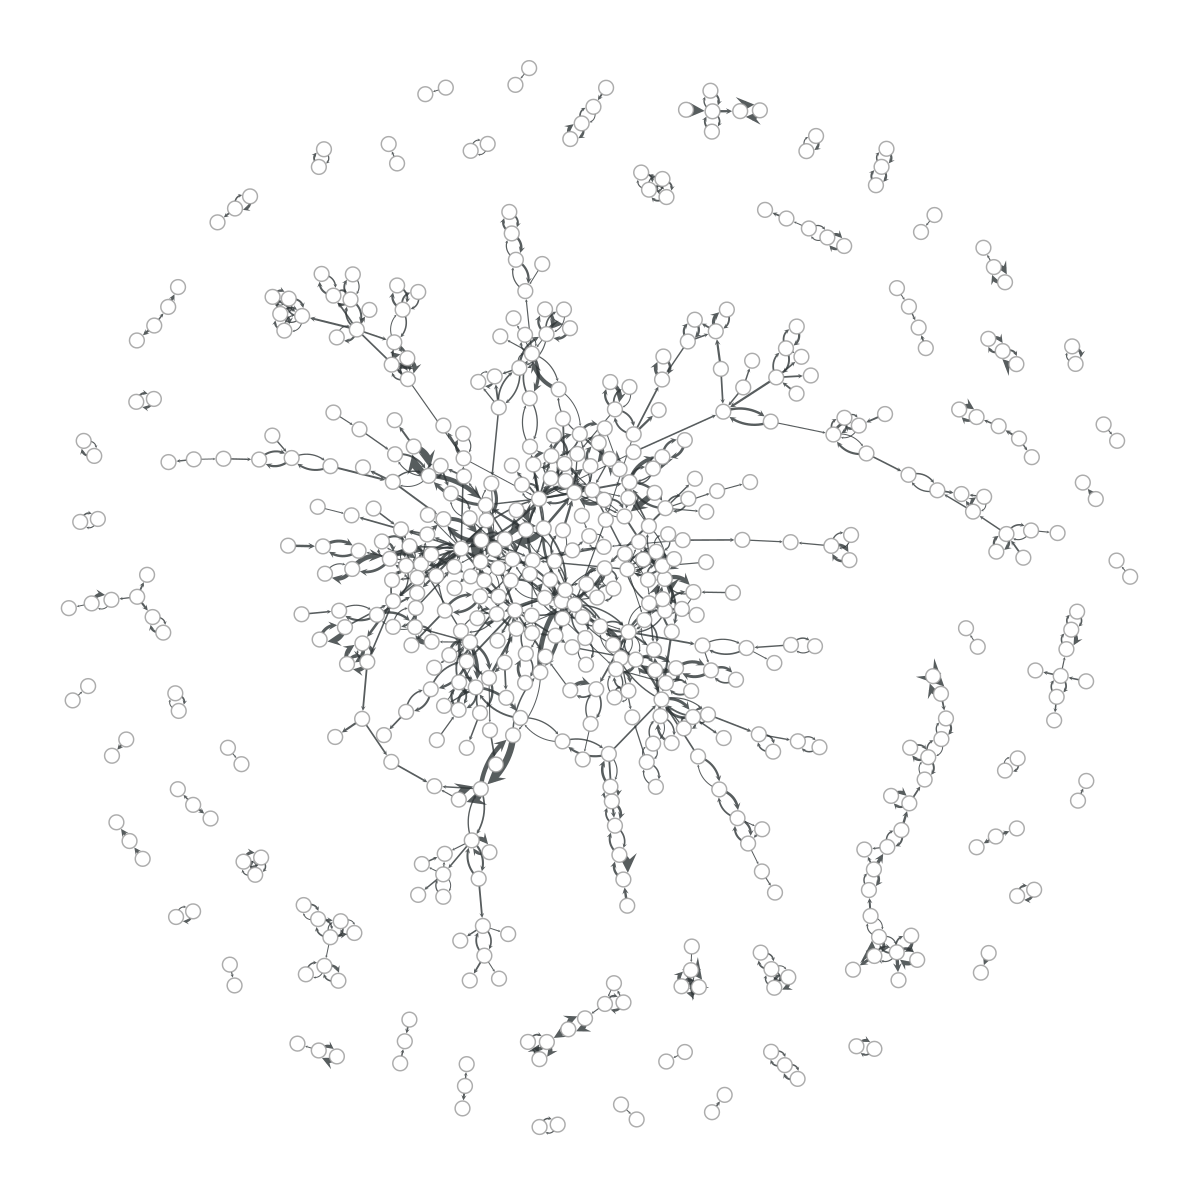

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f29781cf050, at 0x7f2921061c50>

In [25]:
gt.graph_draw(
    g = gt.GraphView(g=g_calls, vfilt=(g_calls.get_out_degrees(g_calls.get_vertices()) > 0) + (g_calls.get_in_degrees(g_calls.get_vertices()) > 0)), 
    vertex_fill_color = 'white', 
    edge_pen_width = gt.prop_to_size(prop=g_calls_ep_weight, mi=.5, ma=5)
)

### Layered graph of calls and short messages

Networks can have multiple types of tie. Besides Facebook friendship and who-calls-whom, the Copenhagen Networks Study also provides who has sent a short message to whom. With `graph-tool`, it is possible to construct and analyze such graphs. The trick is to provide an edge list with an additional column on the type of tie. As an example, we construct an edge list of calls and short messages. The edge list of short messages is:

In [26]:
sms.head()

,user_id_from,user_id_to,time,time_bin
0,370,512,1970-01-01 00:00:18,0
1,512,370,1970-01-01 00:00:37,0
2,370,512,1970-01-01 00:02:06,0
3,0,512,1970-01-01 00:02:14,0
4,137,136,1970-01-01 00:05:12,1


To have just one edge per direction, we count the number of messages:

In [27]:
sms_size = sms.groupby(['user_id_from', 'user_id_to']).size().to_frame('weight').reset_index()

Now, we have to combine `calls_duration` and `sms_size` into one edge list. Before we do that, it is a good idea to re-scale the weights of the two edge lists so they are comparable:

In [28]:
calls_sum['weight'] = calls_sum['weight'] / calls_sum['weight'].mean()
sms_size['weight'] = sms_size['weight'] / sms_size['weight'].mean()

Add a column in each dataframe specifying the type of tie or layer:

In [29]:
calls_sum['layer'] = 0
sms_size['layer'] = 1

Now, we can combine them into one `communication` edge list:

In [30]:
communication = pd.concat([calls_sum, sms_size])

All it takes now is to add the type of tie as another integer edge attribute:

In [31]:
g_communication = gt.Graph(directed=True)
g_communication.add_vertex(len(users))
g_communication_ep_weight = g_communication.new_ep('float')
g_communication_ep_layer = g_communication.new_ep('int')
g_communication.add_edge_list(communication.values, eprops=[g_communication_ep_weight, g_communication_ep_layer])

In [32]:
g_communication

<Graph object, directed, with 845 vertices and 2227 edges, at 0x7f29210607d0>

In [33]:
pos_communication = gt.sfdp_layout(g_communication)

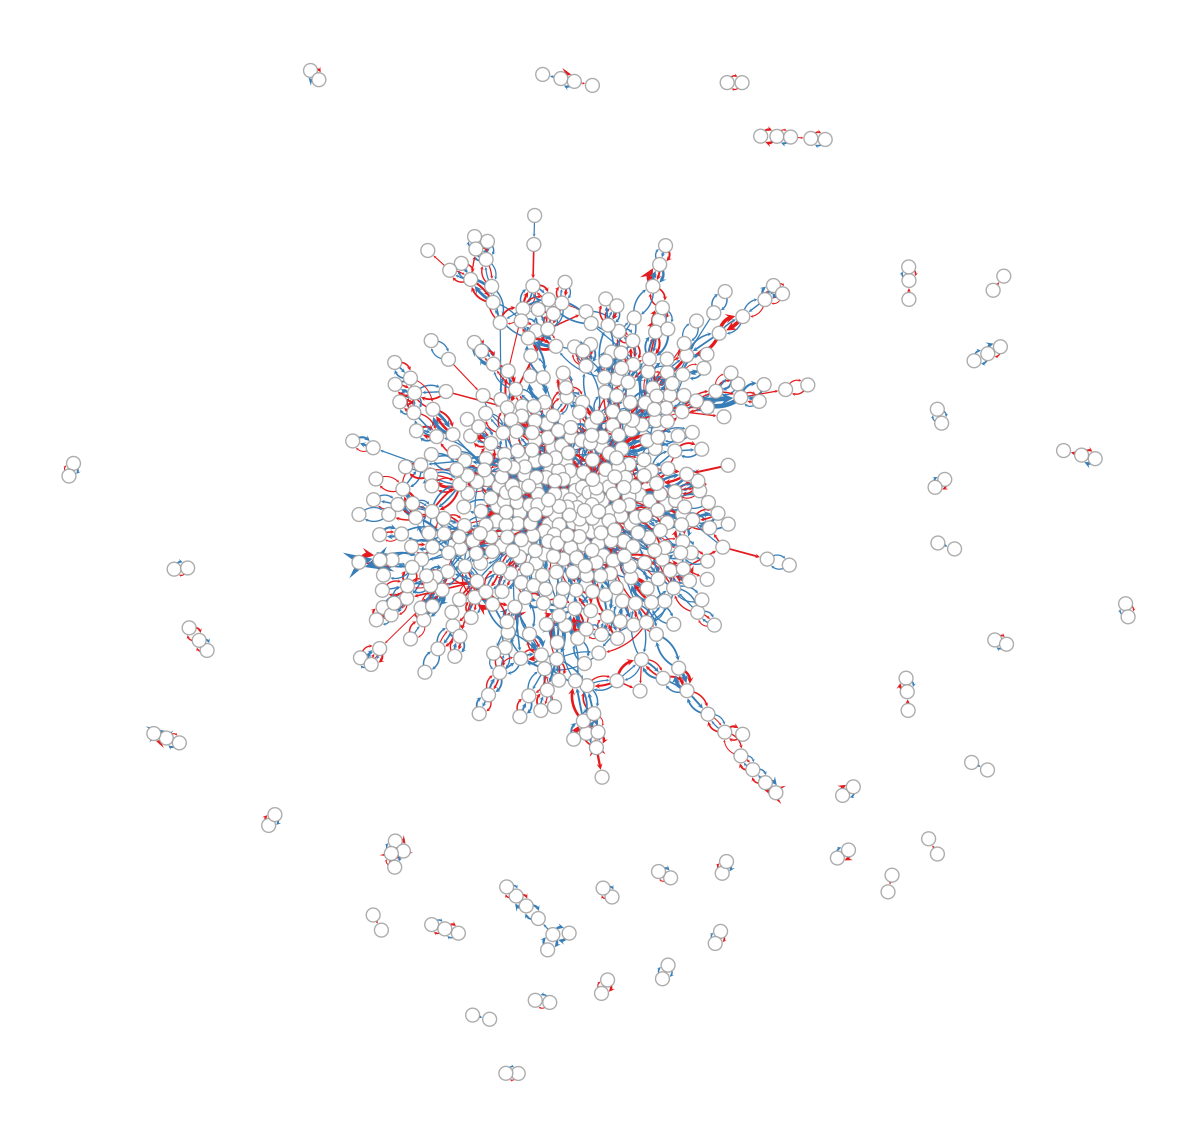

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f29210607d0, at 0x7f29210612d0>

In [34]:
gt.graph_draw(
    g = gt.GraphView(g=g_communication, vfilt=(g_communication.get_out_degrees(g_communication.get_vertices()) > 0) + (g_communication.get_in_degrees(g_communication.get_vertices()) > 0)), 
    pos = pos_communication, 
    vertex_fill_color = 'white', 
    edge_color = g_communication_ep_layer, 
    edge_pen_width = gt.prop_to_size(prop=g_communication_ep_weight, mi=.5, ma=5), 
    ecmap = colormaps['Set1']
)

<div class='alert alert-info'>
<big><b>Info</b></big>

`graph-tool` adds edges one by one from an edge list, even when the graph is multiplex. Multiplex ties are simply parallel edges with different attributes. It means that if an edge is in the edge list twice without differences in its attribute(s), then it will be a parallel edge in the respective layer. Time slices of a graph can also be stored as edge attributes. All this makes graph construction very straightforward.
</div>

### Internalizing property maps

Until now all vertex and edge property maps are still external to the `Graph` object. But we can also internalize any property, which means, make it part of the `Graph` object. The vertex properties of the friendship network are internalized like this:

In [35]:
g_facebook_friends.vp['gender_id'] = g_facebook_friends_vp_gender_id
g_facebook_friends.vp['num_friends'] = g_facebook_friends_vp_num_friends

In [36]:
g_facebook_friends.list_properties()

gender_id       (vertex)  (type: int32_t)
num_friends     (vertex)  (type: int32_t)


The edge attributes of the calls network are internalized like this:

In [37]:
g_communication.ep['weight'] = g_communication_ep_weight
g_communication.ep['layer'] = g_communication_ep_layer

In [38]:
g_communication.list_properties()

layer          (edge)    (type: int32_t)
weight         (edge)    (type: double)


Internal property maps can be accessed like external one, for example in drawing.

## Function

`compsoc`'s `construct_graph()` function constructs a graph-tool `Graph` object from pandas node and edge lists. Users just need to specify which columns of the lists contain attributes that should be internalized and what data types they are. All attributes, including a graph attribute to give the network a name, are internalized. The function automatically performs a check if the node list meets the requirements:

In [39]:
def construct_graph(
    node_list, 
    node_identifier, 
    edge_list, 
    directed = True, 
    graph_name = None, 
    node_properties = None, 
    node_property_types = None, 
    edge_properties = None, 
    edge_property_types = None
):
    '''
    Description: Constructs a graph, using graph-tool, from pandas node and edge lists.
    
    Inputs:
        node_list: pandas dataframe containing the node identifiers and properties; must 
            contain a continuous identifier from 0 to N-1 where N is the number of vertices; 
            node attributes must be in additional columns.
        node_identifier: Column name of the node list that contains the node identifier.
        edge_list: pandas dataframe containing a node identifier pair per edge; edge 
            attributes must be in additional columns.
        directed: If graph should be directed (boolean); set to True by default.
        graph_name: Name of the graph (string); set to None by default.
        node_properties: List of column names of the node list that contains node attributes 
            that are to be internalized in the graph; set to None by default.
        node_property_types: List of data types corresponding to the node properties list; 
            values must be from the set given at 
            https://graph-tool.skewed.de/static/doc/quickstart.html#property-maps; set to None 
            by default.
        edge_properties: List of column names of the edge_list that contains edge attributes 
            that are to be internalized in the graph; set to None by default.
        edge_property_types: List of data types corresponding to the edge properties list; 
            values must be from the set given at 
            https://graph-tool.skewed.de/static/doc/quickstart.html#property-maps; set to None 
            by default.
    
    Output: graph-tool graph object, with internal graph, vertex, and edge attributes, if 
        specified.
    '''
    # node list check
    node_list = node_list.sort_values(node_identifier, ascending=True).reset_index(drop=True)
    check = node_list[node_identifier] == node_list.index
    if (sum(check) == len(node_list)) == False:
        print('The node list dataframe does not meet the requirements. Check if the'+node_identifier+'column contains integers from zero to N-1 where N is the number of vertices in the graph.')
    
    # create graph
    import graph_tool.all as gt
    g = gt.Graph(directed=directed)
    
    if graph_name != None:
        # write graph name
        g.gp['name'] = g.new_gp('string')
        g.gp['name'] = graph_name
    
    # write vertices
    g.add_vertex(len(node_list))
    
    if node_properties != None:
        # create i internal vertex property maps
        for i in range(len(node_properties)):
            g.vp[node_properties[i]] = g.new_vp(node_property_types[i])
        
        # write scalar vertex attributes
        scalar_types = ['bool', 'uint8_t', 'int16_t', 'short', 'int32_t', 'int', 'int64_t', 'long', 'long long', 'double', 'float', 'long double']
        node_property_types_indices_scalar = [i for i, j in enumerate(node_property_types) if j in scalar_types]
        for i in node_property_types_indices_scalar:
            g.vp[node_properties[i]].a = node_list[node_properties[i]]
        
        # write non-scalar vertex attributes
        node_property_types_indices_nonscalar = [i for i, j in enumerate(node_property_types) if j not in scalar_types]
        for v in range(len(node_list)):
            for i in node_property_types_indices_nonscalar:
                g.vp[node_properties[i]][v] = node_list[node_properties[i]][v]
    
    columns = list(edge_list.columns[:2])
    if edge_properties != None:
        # create i internal edge property maps
        for i in range(len(edge_properties)):
            g.ep[edge_properties[i]] = g.new_ep(edge_property_types[i])
        
        # write edges with attributes 
        [columns.append(edge_property) for edge_property in edge_properties]
        eprops = [g.ep[edge_properties[i]] for i in range(len(edge_properties))]
        g.add_edge_list(edge_list[columns].values, eprops=eprops)
    else:
        # write edges
        g.add_edge_list(edge_list[columns].values)
    
    return g

## Using the function

Re-construct the multiplex communication graph, this time with all node attributes:

In [40]:
g_communication = cs.construct_graph(
    node_list = users, 
    edge_list = communication, 
    node_identifier = 'user_id', 
    graph_name = 'g_communication', 
    node_properties = ['gender_id', 'num_friends'], 
    node_property_types = ['int', 'int'], 
    edge_properties = ['weight', 'layer'], 
    edge_property_types=['float', 'int']
)

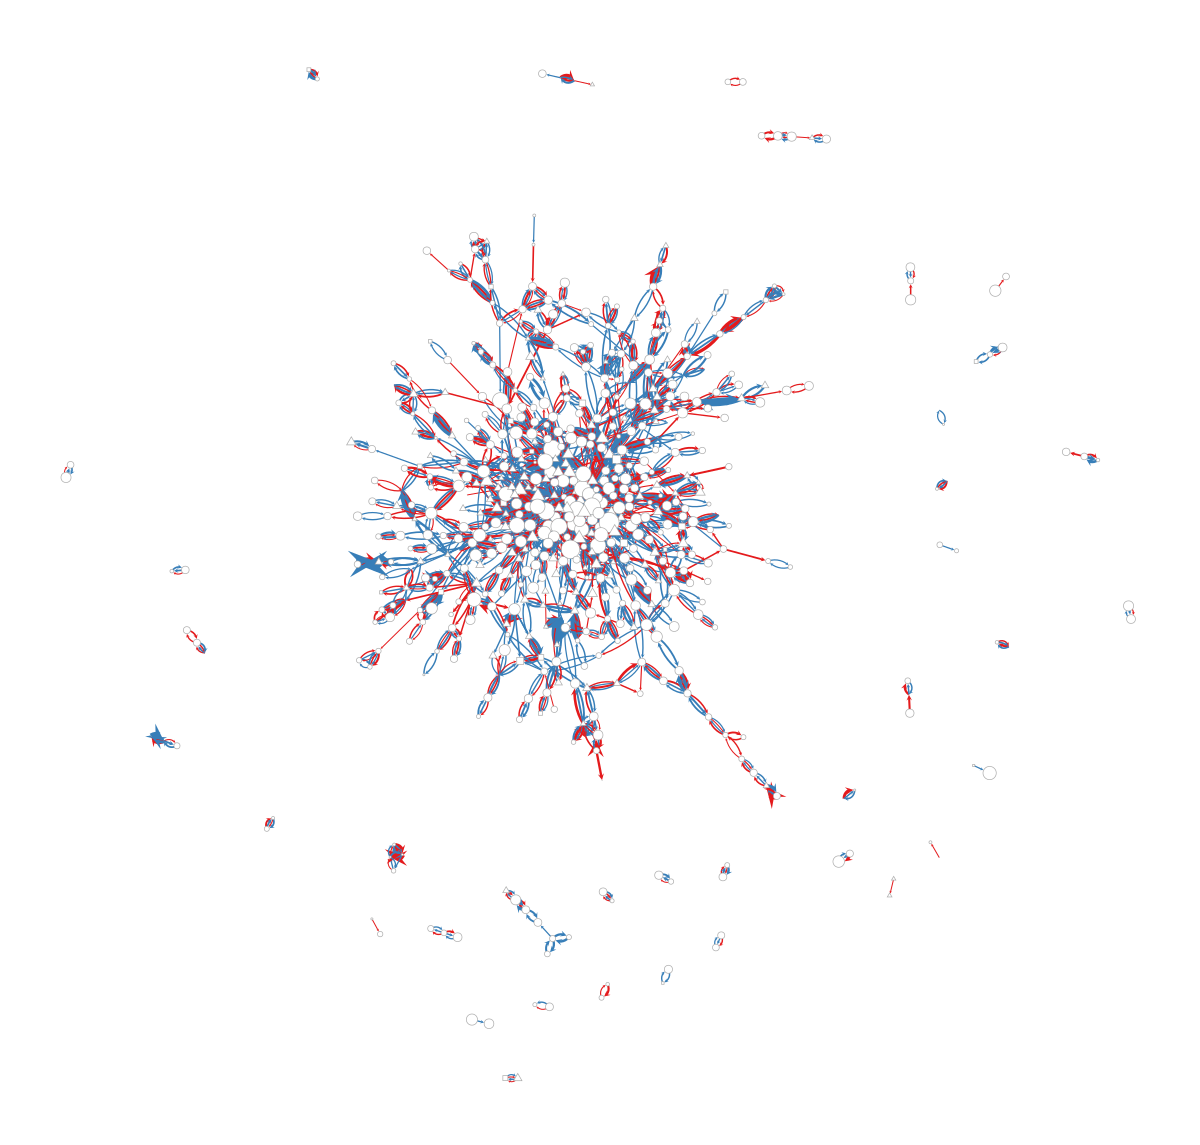

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2926eabb50, at 0x7f2915251390>

In [41]:
gt.graph_draw(
    g = gt.GraphView(g=g_communication, vfilt=(g_communication.get_out_degrees(g_communication.get_vertices()) > 0) + (g_communication.get_in_degrees(g_communication.get_vertices()) > 0)), 
    pos = pos_communication, 
    vertex_fill_color = 'white', 
    vertex_size = gt.prop_to_size(prop=g_communication.vp['num_friends'], mi=.1, ma=10), 
    vertex_shape = g_communication.vp['gender_id'], 
    edge_color = g_communication.ep['layer'], 
    edge_pen_width = gt.prop_to_size(prop=g_communication.ep['weight'], mi=.5, ma=5), 
    ecmap = colormaps['Set1'], 
)

We see from this visualization that students which communicate with many others (those in the core of the network) tend to have many friends (those with large nodes).

***

## About this tutorial

**License**: CC BY 4.0. Distribute, remix, adapt, and build upon ``compsoc``, even commercially, as long as you credit us for the original creation.

**Suggested citation**: Lietz, H. (2025). Constructing networks from node and edge lists. Version 1.0 (XX.XX.XXXX). *compsoc – Computational Social Methods in Python*. Cologne: GESIS – Leibniz Institute for the Social Sciences. https://github.com/gesiscss/compsoc